In [1]:
from matplotlib import pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
import os
import cv2

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

import umap

u_map = umap.UMAP()

from shapes_utils import *


c:\Users\MaryBeth\anaconda3\envs\visualstream\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = os.getcwd()
mp4 = r"frames_0-499\mp4_frames_0-499.mp4"
mp4_path = os.path.join(cwd, mp4)

In [3]:
def load_and_preprocess_image(image, normalize=False):
    """Normalize pixel values if specified."""
    if normalize:
        # Normalize pixel values to [0, 1]
        image = image / 255.0
    else:
        # Ensure pixel values are in the range [0, 255]
        image = np.clip(image, 0, 255).astype(np.uint8)
    return image

### Generate motion frames

(2160, 3840, 3)


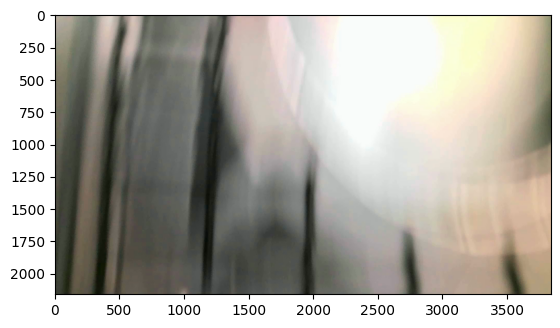

In [4]:
cap = cv2.VideoCapture(mp4)
ret, frame = cap.read()
#gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

print(frame.shape)
plt.imshow(frame)

In [13]:
normalize = False
gpu = False

def prepare_frames_and_optical_flow(video_path, normalize=normalize, gpu=gpu):
    # Initialize the video reader
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Failed to open the video")
        return [], [], []

    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    half_frames = total_frames // 2

    ret, prev_frame = cap.read()
    if not ret:
        print("Failed to read the video")
        return [], [], []

    # Convert first frame to grayscale for optical flow calculation
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Prepare lists to hold processed frames
    normal_frames = []
    flow_frames = []
    difference_frames = []

    if gpu:
        # Initialize CUDA optical flow algorithm
        gpu_prev_gray = cv2.cuda_GpuMat()
        gpu_prev_gray.upload(prev_gray)
        optical_flow_gpu = cv2.cuda_FarnebackOpticalFlow.create(5, 0.5, False, 15, 3, 5, 1.2, 0)

    frame_count = 1

    while frame_count <= half_frames: #True: #frame_count <= half_frames:
        ret, frame = cap.read()
        if not ret:
            break

        normal_frame = load_and_preprocess_image(frame, normalize=normalize)
        normal_frames.append(normal_frame)

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if gpu:

            gpu_gray = cv2.cuda_GpuMat()
            gpu_gray.upload(gray)

            # Compute the optical flow using Farneback's method on GPU
            gpu_flow = optical_flow_gpu.calc(gpu_prev_gray, gpu_gray, None)
            gpu_flow = gpu_flow.download()

            # Create HSV image to visualize the flow
            hsv = np.zeros_like(frame)
            mag, ang = cv2.cartToPolar(gpu_flow[..., 0], gpu_flow[..., 1])
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 1] = 255
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            flow_frame = load_and_preprocess_image(flow_bgr, normalize=normalize)
            flow_frames.append(flow_frame)
            gpu_prev_gray = gpu_gray

        else:

            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            hsv = np.zeros_like(frame)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang*180/np.pi/2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            flow_frame = load_and_preprocess_image(flow_bgr, normalize=normalize)
            flow_frames.append(flow_frame)
                        

        # Compute frame differencing
        difference_frame = cv2.absdiff(gray, prev_gray)
        difference_frame = load_and_preprocess_image(difference_frame)
        difference_frames.append(difference_frame)

        # Update the previous frame and its grayscale version
        # gpu_prev_gray = gpu_gray
        prev_frame = frame
        prev_gray = gray
        
        frame_count += 1

    cap.release()
    return normal_frames, flow_frames, difference_frames

In [14]:
normal_images, optical_flow_images, difference_images = prepare_frames_and_optical_flow(mp4)

normal_images = np.asarray(normal_images)
optical_flow_images = np.asarray(optical_flow_images)
difference_images = np.asarray(difference_images)

(2160, 3840)


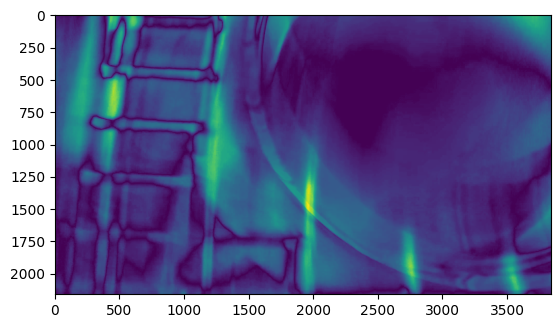

In [15]:
print(difference_images[0].shape)
plt.imshow(difference_images[0])

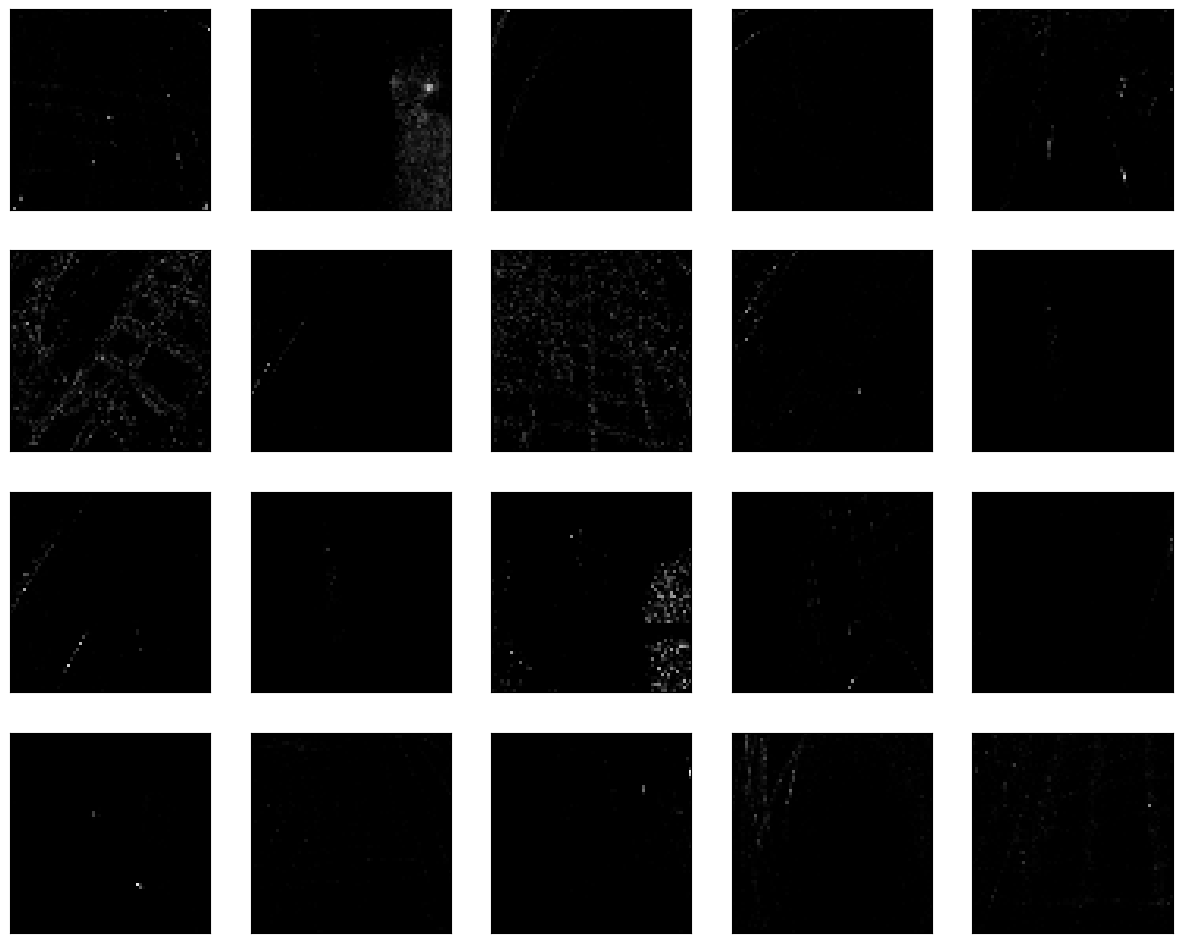

In [17]:
batch_size =  20
target_size = 60
n_samples = difference_images.shape[0]
n_channels = 1
img_batch = sample_random_batch(batch_size, n_samples, optical_flow_images)
show_images_grid(img_batch)

In [1]:
start_index = np.random.randint(0, len(difference_images)-20)

for idx in range(start_index,start_index+21):
    optical_flow_img = optical_flow_images[idx]
    normal_img = normal_images[idx] 
    difference_img = difference_images[idx]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(normal_img)
    axes[0].set_title('Visual Stream Image')
    axes[0].axis('off')

    # axes[1].imshow(optical_flow_img)
    # axes[1].set_title('Optical Flow Image')
    # axes[1].axis('off')

    axes[1].imshow(difference_img)
    axes[1].set_title('Frame Difference Image')
    axes[1].axis('off')

    plt.show()

NameError: name 'np' is not defined

In [18]:
batch_size = 100
img_batch = sample_random_batch(batch_size, n_samples, difference_images)
resized_images = np.array([np.stack([cv2.resize(img, (224, 224))]*3, axis=-1) if len(img.shape) == 2 else cv2.resize(img, (224, 224)) for img in img_batch])

In [12]:
model = ResNet50(weights='imagenet', include_top=False)

In [19]:
features_resnet = [extract_features(img, model) for img in resized_images]
features_array_resnet = np.array(features_resnet)
features_reshaped_resnet = features_array_resnet.reshape((features_array_resnet.shape[0], -1))

1/1 [==============================] - 0s 108ms/step


In [20]:
print(np.shape(features_reshaped_resnet))

(100, 100352)


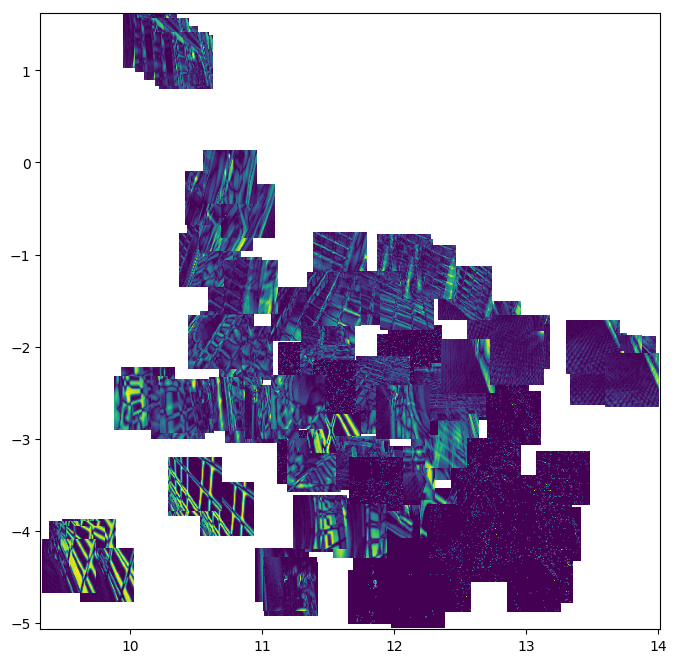

In [21]:
import umap

u_map = umap.UMAP()
umap_embedding = u_map.fit_transform(features_reshaped_resnet)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot with images
imscatter(umap_embedding[:, 0], umap_embedding[:, 1], img_batch, zoom=0.6, ax=ax)
